In [1]:
import pandas as pd
import seaborn as sns
import tensorflow as tf
from funcs import get_data_per_category, set_dataset

2024-10-30 17:30:13.549230: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-30 17:30:13.589981: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-30 17:30:13.614408: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-30 17:30:13.625125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-30 17:30:13.662831: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df = pd.read_csv('../data/Desafio Ds 2025 - Gen AI/series.csv')

In [3]:
df

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61
...,...,...,...
2681,CATEG-1,2021-02-18,78
2682,CATEG-2,2020-12-05,8
2683,CATEG-2,2020-02-05,3
2684,CATEG-2,2020-06-05,106


In [4]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [5]:
print(df['DATE'].min())
print(df['DATE'].max())
print(df['DATE'].max() - df['DATE'].min())

2018-09-24 00:00:00
2021-11-12 00:00:00
1145 days 00:00:00


In [6]:
df['DAYWEEK'] = df['DATE'].dt.dayofweek

In [7]:
# TODO: Revisar dias faltantes e interpolarlos de existir
# TODO: Revisar unidades negativas

In [8]:
data_train = df[df['DATE'] < '2021-01-01']
data_val = df[(df['DATE'] < '2021-09-01') & (df['DATE'] >= '2021-01-01')]
data_test = df[df['DATE'] >= '2021-09-01']

In [9]:
data_train['CATEGORY'].value_counts()

CATEGORY
CATEG-3    604
CATEG-1    571
CATEG-2    563
Name: count, dtype: int64

In [10]:
data_val['CATEGORY'].value_counts()

CATEGORY
CATEG-1    243
CATEG-2    243
CATEG-3    243
Name: count, dtype: int64

In [11]:
data_train = get_data_per_category(data_train)
data_val = get_data_per_category(data_val)
data_train['CATEG-1']

,DATE,UNITS_SOLD,DAYWEEK
1526,2018-10-16,1,1
506,2019-06-11,27,1
1539,2019-06-12,26,2
423,2019-06-13,24,3
2222,2019-06-14,18,4
...,...,...,...
451,2020-12-27,83,6
2168,2020-12-28,99,0
1087,2020-12-29,112,1
2132,2020-12-30,112,2


In [12]:
for key in data_train:
    data_train[key] = set_dataset(data_train[key][['UNITS_SOLD', 'DAYWEEK']], seq_length=30)
    data_val[key] = set_dataset(data_val[key][['UNITS_SOLD', 'DAYWEEK']], seq_length=30)

I0000 00:00:1730320215.587319  418582 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730320215.857011  418582 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730320215.857046  418582 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730320215.881470  418582 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1730320215.881518  418582 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [13]:
data_train = data_train['CATEG-1']
data_val = data_val['CATEG-1']
data_val

<_BatchDataset element_spec=(TensorSpec(shape=(None, None, 2), dtype=tf.int64, name=None), TensorSpec(shape=(None, None, None), dtype=tf.int64, name=None))>

In [14]:
for inputs, targets in data_val.take(1):
    print("Input shape:", inputs.shape)
    print("Target shape:", targets.shape)

Input shape: (32, 30, 2)
Target shape: (32, 30, 21)


2024-10-30 17:30:16.723207: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=50, restore_best_weights=True)

model = tf.keras.Sequential([tf.keras.layers.Input(shape=[None, 2]), 
                             tf.keras.layers.GRU(2000, return_sequences=True), 
                             tf.keras.layers.GRU(2000, return_sequences=True), 
                             tf.keras.layers.Dense(21)])

model.compile(loss=tf.keras.losses.Huber(), optimizer='adam', metrics=['mae'])

history = model.fit(data_train, validation_data=data_val, epochs=100000, callbacks=[early_stopping_cb])

Epoch 1/100000


2024-10-30 17:30:21.779280: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


     16/Unknown 2s 54ms/step - loss: 2.0426 - mae: 2.4991

2024-10-30 17:30:23.183874: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:30:23.183918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:23.183935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:23.183939: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
/home/nicomore/miniconda3/envs/tf-wsl/lib/python3.9/contextlib.py:137: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 1.9888 - mae: 2.4443 - val_loss: 1.1345 - val_mae: 1.5731
Epoch 2/100000
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.3442 - mae: 1.7855

2024-10-30 17:30:23.386179: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:30:23.386217: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:23.386222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:23.386226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 1.0356 - mae: 1.4547 - val_loss: 0.8581 - val_mae: 1.2642
Epoch 3/100000


2024-10-30 17:30:24.284859: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:24.284892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:24.284896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:24.284899: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:24.284900: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:24.427233: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:30:24.427268: I tensorflow/core/framework/local_rende

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.5341 - mae: 0.8888 - val_loss: 0.3063 - val_mae: 0.6117
Epoch 4/100000


2024-10-30 17:30:25.295013: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:25.295044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:25.295048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:25.433459: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:25.433541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:25.433555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3670 - mae: 0.6812

2024-10-30 17:30:26.286320: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:26.286350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:26.286354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:26.286357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:26.286359: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:26.470405: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:30:26.470442: I tensorflow/core/framework/local_rende

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.3686 - mae: 0.6822 - val_loss: 0.2162 - val_mae: 0.4719
Epoch 5/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.2116 - mae: 0.4530

2024-10-30 17:30:27.695143: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:27.695172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:27.695176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:27.695179: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:27.695180: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:27.857157: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:27.857187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.2098 - mae: 0.4499 - val_loss: 0.1078 - val_mae: 0.2803
Epoch 6/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.1214 - mae: 0.2985

2024-10-30 17:30:28.880027: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:28.880055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:28.880059: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:28.880062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:28.880064: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:29.056568: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:29.056663: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1209 - mae: 0.2972 - val_loss: 0.0846 - val_mae: 0.2343
Epoch 7/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0935 - mae: 0.2412 - val_loss: 0.0646 - val_mae: 0.1720
Epoch 8/100000


2024-10-30 17:30:30.205140: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:30.205195: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:30.205227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:30.205243: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:30.205246: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:30.350103: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:30.350153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0727 - mae: 0.1812

2024-10-30 17:30:31.469336: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:31.469364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:31.469369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:31.469372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:31.469373: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:31.630206: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:30:31.630265: I tensorflow/core/framework/local_rende

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0725 - mae: 0.1809 - val_loss: 0.0591 - val_mae: 0.1530
Epoch 9/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0606 - mae: 0.1629 - val_loss: 0.0508 - val_mae: 0.1421
Epoch 10/100000


2024-10-30 17:30:32.677698: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:32.677735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:32.677752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:32.677756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:32.829581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:32.829611: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:32.829615: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0581 - mae: 0.1549 - val_loss: 0.0423 - val_mae: 0.1197
Epoch 11/100000


2024-10-30 17:30:33.884744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:33.884773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:33.884778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:34.028495: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:34.028527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:34.028532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0500 - mae: 0.1399 - val_loss: 0.0413 - val_mae: 0.1337
Epoch 12/100000


2024-10-30 17:30:35.251878: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:35.251906: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:35.251910: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:35.410336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:35.410366: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:35.410370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0488 - mae: 0.1358 - val_loss: 0.0429 - val_mae: 0.1320
Epoch 13/100000


2024-10-30 17:30:36.499892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:36.665318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:36.665350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:36.665354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0442 - mae: 0.1199 - val_loss: 0.0393 - val_mae: 0.1380
Epoch 14/100000


2024-10-30 17:30:37.616715: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:37.616747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:37.616752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:37.784697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:37.784769: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:37.784815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0356 - mae: 0.1057

2024-10-30 17:30:38.799496: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:38.799546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:38.799557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:38.799565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:38.799569: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:38.961494: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:38.961527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0355 - mae: 0.1054 - val_loss: 0.0311 - val_mae: 0.1009
Epoch 15/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0319 - mae: 0.0934

2024-10-30 17:30:40.420747: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:40.420793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:40.420804: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:40.420812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:40.420816: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - loss: 0.0318 - mae: 0.0932 - val_loss: 0.0278 - val_mae: 0.0864
Epoch 16/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0317 - mae: 0.0904

2024-10-30 17:30:40.716904: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:40.716943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:40.716949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0294 - mae: 0.0851

2024-10-30 17:30:41.815815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:41.815838: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:41.972791: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:30:41.972849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:41.972854: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:41.972857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0293 - mae: 0.0849 - val_loss: 0.0258 - val_mae: 0.0833
Epoch 17/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0271 - mae: 0.0793 - val_loss: 0.0237 - val_mae: 0.0747
Epoch 18/100000


2024-10-30 17:30:43.231982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:43.232030: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:43.232040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:43.380007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:43.380040: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:43.380044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0253 - mae: 0.0744

2024-10-30 17:30:44.465649: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:44.465695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:44.465705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:44.465713: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:44.465717: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0252 - mae: 0.0742 - val_loss: 0.0222 - val_mae: 0.0714
Epoch 19/100000
 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0264 - mae: 0.0800

2024-10-30 17:30:44.676173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:44.676223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:44.676235: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0237 - mae: 0.0726 - val_loss: 0.0209 - val_mae: 0.0714
Epoch 20/100000


2024-10-30 17:30:45.749581: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:45.749628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:45.749639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:45.749647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:45.749651: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:45.902798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:45.902828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0227 - mae: 0.0733

2024-10-30 17:30:46.966821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:46.966846: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:46.966850: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:47.128147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:47.128178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:47.128182: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0226 - mae: 0.0732 - val_loss: 0.0197 - val_mae: 0.0664
Epoch 21/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0214 - mae: 0.0708

2024-10-30 17:30:48.257969: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:48.258036: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:48.258050: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:48.258054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:48.258055: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:48.420307: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:48.420338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0213 - mae: 0.0706 - val_loss: 0.0186 - val_mae: 0.0633
Epoch 22/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0205 - mae: 0.0695

2024-10-30 17:30:49.474674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:49.474701: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:49.474707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0204 - mae: 0.0695 - val_loss: 0.0179 - val_mae: 0.0650
Epoch 23/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0213 - mae: 0.0747

2024-10-30 17:30:49.742467: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:49.742496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:49.742500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0195 - mae: 0.0698 - val_loss: 0.0173 - val_mae: 0.0631
Epoch 24/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0213 - mae: 0.0816

2024-10-30 17:30:50.912237: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:50.912266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:50.912271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0195 - mae: 0.0741

2024-10-30 17:30:51.939296: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:51.939342: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:51.939353: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:51.939361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:51.939366: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:52.100529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:52.100558: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0194 - mae: 0.0740 - val_loss: 0.0168 - val_mae: 0.0636
Epoch 25/100000
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0185 - mae: 0.0697

2024-10-30 17:30:53.366750: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:53.366819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:53.366834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:53.366836: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:53.556634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:53.556664: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:53.556668: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0184 - mae: 0.0696 - val_loss: 0.0162 - val_mae: 0.0610
Epoch 26/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0181 - mae: 0.0705 - val_loss: 0.0161 - val_mae: 0.0629
Epoch 27/100000


2024-10-30 17:30:54.793882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:54.793907: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:54.793911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:54.959627: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:54.959657: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:54.959661: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0180 - mae: 0.0711 - val_loss: 0.0160 - val_mae: 0.0669
Epoch 28/100000


2024-10-30 17:30:55.976732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:55.976758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:55.976762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:56.125291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:56.125324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:56.125329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0170 - mae: 0.0659

2024-10-30 17:30:57.156728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:57.156775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:57.156787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:57.156792: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:30:57.330140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:57.330172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:57.330176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0170 - mae: 0.0658 - val_loss: 0.0147 - val_mae: 0.0539
Epoch 29/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0164 - mae: 0.0618 - val_loss: 0.0147 - val_mae: 0.0586
Epoch 30/100000


2024-10-30 17:30:58.402328: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:58.402365: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:58.402383: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:58.402387: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:58.546652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:58.546681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:58.546685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0164 - mae: 0.0664

2024-10-30 17:30:59.672866: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:30:59.672896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:30:59.672900: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:30:59.672902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:30:59.672904: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0163 - mae: 0.0663 - val_loss: 0.0143 - val_mae: 0.0584
Epoch 31/100000
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0166 - mae: 0.0622

2024-10-30 17:30:59.891072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:30:59.891101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:30:59.891105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0154 - mae: 0.0585 - val_loss: 0.0136 - val_mae: 0.0524
Epoch 32/100000


2024-10-30 17:31:00.821073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:00.821104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:00.821108: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:00.970897: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:00.970931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:00.970935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0153 - mae: 0.0598

2024-10-30 17:31:02.009138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:02.009170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:02.009174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:02.194940: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:31:02.194996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:02.195007: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:02.195042: I tensorflow/core/framework/local_rendezvo

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0152 - mae: 0.0595 - val_loss: 0.0133 - val_mae: 0.0516
Epoch 33/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0148 - mae: 0.0579

2024-10-30 17:31:03.437010: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:03.437062: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:03.437080: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:03.437085: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0148 - mae: 0.0579 - val_loss: 0.0130 - val_mae: 0.0530
Epoch 34/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0160 - mae: 0.0640

2024-10-30 17:31:03.693569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:03.693653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:03.693669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0144 - mae: 0.0580

2024-10-30 17:31:04.958310: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:04.958340: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:04.958344: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:04.958346: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:04.958348: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0144 - mae: 0.0579 - val_loss: 0.0124 - val_mae: 0.0458
Epoch 35/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0156 - mae: 0.0610

2024-10-30 17:31:05.177154: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:05.177185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:05.177189: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0140 - mae: 0.0554

2024-10-30 17:31:06.517944: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:06.518023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:06.518037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:06.518045: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:06.518049: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0140 - mae: 0.0553 - val_loss: 0.0121 - val_mae: 0.0465
Epoch 36/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0152 - mae: 0.0581

2024-10-30 17:31:06.810720: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:06.810754: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:06.810758: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0137 - mae: 0.0539

2024-10-30 17:31:08.150961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:08.150988: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:08.150993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 0.0136 - mae: 0.0538 - val_loss: 0.0117 - val_mae: 0.0432
Epoch 37/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0149 - mae: 0.0565

2024-10-30 17:31:08.400928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:08.400970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:08.400975: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0133 - mae: 0.0530

2024-10-30 17:31:09.687082: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:09.687111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:09.687115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:09.687118: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:09.687120: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0133 - mae: 0.0529 - val_loss: 0.0114 - val_mae: 0.0445
Epoch 38/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0145 - mae: 0.0564

2024-10-30 17:31:09.903061: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:09.903097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:09.903101: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0129 - mae: 0.0516

2024-10-30 17:31:11.250511: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:11.250538: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:11.250542: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:11.250545: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:11.250546: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0129 - mae: 0.0515 - val_loss: 0.0111 - val_mae: 0.0466
Epoch 39/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0146 - mae: 0.0611

2024-10-30 17:31:11.460491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:11.460553: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:11.460564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0128 - mae: 0.0543

2024-10-30 17:31:12.696849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:12.696882: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:12.696886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0128 - mae: 0.0542 - val_loss: 0.0107 - val_mae: 0.0439
Epoch 40/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0140 - mae: 0.0571

2024-10-30 17:31:12.904487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:12.904522: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:12.904526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0124 - mae: 0.0523

2024-10-30 17:31:14.145025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:14.145052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:14.145057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0123 - mae: 0.0522 - val_loss: 0.0106 - val_mae: 0.0491
Epoch 41/100000
 1/17 ━━━━━━━━━━━━━━━━━━━━ 2s 151ms/step - loss: 0.0147 - mae: 0.0694

2024-10-30 17:31:14.349993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:14.350021: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:14.350028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0122 - mae: 0.0580 - val_loss: 0.0105 - val_mae: 0.0530
Epoch 42/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0144 - mae: 0.0742

2024-10-30 17:31:16.024389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:16.024421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:16.024425: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.0124 - mae: 0.0637

2024-10-30 17:31:17.241688: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:17.241738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:17.241751: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:17.241759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:17.241763: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0123 - mae: 0.0635 - val_loss: 0.0106 - val_mae: 0.0567
Epoch 43/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0152 - mae: 0.0784

2024-10-30 17:31:17.447180: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:17.447209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:17.447213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0127 - mae: 0.0661

2024-10-30 17:31:18.630862: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:18.630890: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:18.630895: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0126 - mae: 0.0660 - val_loss: 0.0109 - val_mae: 0.0617
Epoch 44/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0167 - mae: 0.0891

2024-10-30 17:31:18.895752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:18.895787: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:18.895792: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 0.0135 - mae: 0.0742

2024-10-30 17:31:20.286262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:20.286291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:20.286296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - loss: 0.0134 - mae: 0.0741 - val_loss: 0.0101 - val_mae: 0.0580
Epoch 45/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0155 - mae: 0.0803

2024-10-30 17:31:20.500572: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:20.500600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:20.500604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0129 - mae: 0.0710

2024-10-30 17:31:21.756555: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:21.756583: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:21.756587: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:21.756590: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:21.756591: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0129 - mae: 0.0709 - val_loss: 0.0097 - val_mae: 0.0567
Epoch 46/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0145 - mae: 0.0832 

2024-10-30 17:31:21.979438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:21.979527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:21.979541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0122 - mae: 0.0717 - val_loss: 0.0088 - val_mae: 0.0527
Epoch 47/100000


2024-10-30 17:31:23.023471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:23.023499: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:23.023503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:23.177375: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:23.177406: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:23.177411: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0110 - mae: 0.0639 - val_loss: 0.0086 - val_mae: 0.0508
Epoch 48/100000


2024-10-30 17:31:24.184981: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:24.185055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:24.185069: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:24.185072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:24.185074: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:24.340491: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:24.340523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0102 - mae: 0.0576 - val_loss: 0.0078 - val_mae: 0.0463
Epoch 49/100000


2024-10-30 17:31:25.415348: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:25.415381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:25.415424: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:25.415428: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:25.558285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:25.558317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:25.558321: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0093 - mae: 0.0501

2024-10-30 17:31:26.497147: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:26.497177: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:26.497181: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:26.665793: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:26.665823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:26.665828: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0092 - mae: 0.0499 - val_loss: 0.0071 - val_mae: 0.0390
Epoch 50/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0087 - mae: 0.0487 - val_loss: 0.0068 - val_mae: 0.0414
Epoch 51/100000


2024-10-30 17:31:27.716656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:27.716678: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:27.716683: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:27.856377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:27.856521: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:27.856539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0082 - mae: 0.0454 - val_loss: 0.0062 - val_mae: 0.0329
Epoch 52/100000


2024-10-30 17:31:28.852777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:28.852826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:28.852837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:28.990886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:28.990914: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:28.990919: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0077 - mae: 0.0415 - val_loss: 0.0060 - val_mae: 0.0357
Epoch 53/100000


2024-10-30 17:31:30.103962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:30.103994: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:30.103999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:30.253081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:30.253111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:30.253115: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0074 - mae: 0.0407

2024-10-30 17:31:31.249740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:31.249767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:31.249771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:31.406844: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:31.406875: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:31.406879: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0074 - mae: 0.0406 - val_loss: 0.0057 - val_mae: 0.0327
Epoch 54/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0071 - mae: 0.0394 - val_loss: 0.0058 - val_mae: 0.0401
Epoch 55/100000


2024-10-30 17:31:32.450740: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:32.450764: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:32.450768: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:32.606302: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:32.606330: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:32.606334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0072 - mae: 0.0427 - val_loss: 0.0058 - val_mae: 0.0441
Epoch 56/100000


2024-10-30 17:31:33.598230: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:33.598264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:33.598268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:33.598271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:33.598273: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:33.754375: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:33.754405: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0086 - mae: 0.0546 - val_loss: 0.0058 - val_mae: 0.0544
Epoch 57/100000


2024-10-30 17:31:34.808655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:34.808681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:34.808685: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:34.950490: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:34.950525: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:34.950529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0117 - mae: 0.0664 - val_loss: 0.0418 - val_mae: 0.1599
Epoch 58/100000


2024-10-30 17:31:35.935301: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:35.935325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:35.935329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:36.082569: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:36.082600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:36.082605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0266 - mae: 0.1292 - val_loss: 0.0813 - val_mae: 0.1938
Epoch 59/100000


2024-10-30 17:31:37.058777: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:37.058845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:37.058857: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:37.058861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:37.058863: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:37.216752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:37.216780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0495 - mae: 0.1573 - val_loss: 0.1205 - val_mae: 0.2619
Epoch 60/100000


2024-10-30 17:31:38.269277: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:38.269324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:38.269335: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:38.269370: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:38.269376: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:38.429023: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:38.429056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.1551 - mae: 0.3447

2024-10-30 17:31:39.476993: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:39.477041: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:39.477052: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:39.477060: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:39.477064: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.1543 - mae: 0.3448 - val_loss: 0.0594 - val_mae: 0.2203
Epoch 61/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0857 - mae: 0.2658

2024-10-30 17:31:39.729440: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:39.729473: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:39.729477: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0583 - mae: 0.2111 - val_loss: 0.0180 - val_mae: 0.1221
Epoch 62/100000


2024-10-30 17:31:40.714184: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:40.714209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:40.714213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:40.863744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:40.863771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:40.863775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0221 - mae: 0.1402 - val_loss: 0.0157 - val_mae: 0.1193
Epoch 63/100000


2024-10-30 17:31:41.855917: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:41.855943: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:41.855948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:42.036746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:42.036777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:42.036781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0284 - mae: 0.1467 - val_loss: 0.0131 - val_mae: 0.1091
Epoch 64/100000


2024-10-30 17:31:43.123036: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:43.123064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:43.123068: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:43.123071: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:43.123072: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:43.283609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:43.283639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0193 - mae: 0.1179 - val_loss: 0.0164 - val_mae: 0.1000
Epoch 65/100000


2024-10-30 17:31:44.246263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:44.246291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:44.246296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:44.409191: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-30 17:31:44.409226: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:44.409230: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:44.409233: I tensorflow/core/framework/local_rendezvo

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0104 - mae: 0.0835 - val_loss: 0.0079 - val_mae: 0.0657
Epoch 66/100000


2024-10-30 17:31:45.433689: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:45.433724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:45.433728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:45.433731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:45.433733: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:45.587377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:45.587408: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0077 - mae: 0.0678 - val_loss: 0.0046 - val_mae: 0.0493
Epoch 67/100000


2024-10-30 17:31:46.571467: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:46.571502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:46.571515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:46.571519: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:46.722185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:46.722221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:46.722227: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0061 - mae: 0.0525 - val_loss: 0.0035 - val_mae: 0.0326
Epoch 68/100000


2024-10-30 17:31:47.708233: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:47.708261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:47.708265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:47.863628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:47.863656: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:47.863660: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0049 - mae: 0.0430 - val_loss: 0.0038 - val_mae: 0.0335
Epoch 69/100000


2024-10-30 17:31:48.884759: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:48.884821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:48.884827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:48.884829: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:49.035362: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:49.035393: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:49.035397: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0041 - mae: 0.0345 - val_loss: 0.0029 - val_mae: 0.0262
Epoch 70/100000


2024-10-30 17:31:50.149452: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:50.149480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:50.149483: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:50.149486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:50.149488: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:31:50.287309: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:50.287336: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0038 - mae: 0.0312

2024-10-30 17:31:51.321143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:51.321187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:51.321192: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:51.485480: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:51.485533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:51.485546: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0037 - mae: 0.0312 - val_loss: 0.0026 - val_mae: 0.0249
Epoch 71/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0034 - mae: 0.0273 - val_loss: 0.0024 - val_mae: 0.0198
Epoch 72/100000


2024-10-30 17:31:52.726902: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:52.726948: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:52.726953: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:52.882178: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:52.882249: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:52.882265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0032 - mae: 0.0235

2024-10-30 17:31:53.937554: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:53.937578: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:53.937582: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:54.106111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:54.106141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:54.106146: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0032 - mae: 0.0234 - val_loss: 0.0023 - val_mae: 0.0194
Epoch 73/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0030 - mae: 0.0219

2024-10-30 17:31:55.263730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:55.263757: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:55.263763: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:55.431501: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:55.431531: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:55.431535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0030 - mae: 0.0218 - val_loss: 0.0022 - val_mae: 0.0191
Epoch 74/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0029 - mae: 0.0217

2024-10-30 17:31:56.541581: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:56.541604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:56.541609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:56.708334: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:56.708368: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:56.708373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0029 - mae: 0.0216 - val_loss: 0.0020 - val_mae: 0.0185
Epoch 75/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0028 - mae: 0.0209 - val_loss: 0.0019 - val_mae: 0.0185
Epoch 76/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0027 - mae: 0.0203

2024-10-30 17:31:58.906100: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:31:58.906134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:31:58.906139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:31:58.906143: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:31:58.906145: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0027 - mae: 0.0202 - val_loss: 0.0019 - val_mae: 0.0187
Epoch 77/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0038 - mae: 0.0245

2024-10-30 17:31:59.113693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:31:59.113725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:31:59.113730: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0026 - mae: 0.0202 - val_loss: 0.0018 - val_mae: 0.0191
Epoch 78/100000


2024-10-30 17:32:00.418849: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:00.418883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:00.418888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:00.418892: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:00.418894: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:00.576005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:00.576039: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0025 - mae: 0.0206 - val_loss: 0.0017 - val_mae: 0.0196
Epoch 79/100000


2024-10-30 17:32:01.714742: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:01.714771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:01.714775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:01.714778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:01.714780: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:01.861259: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:01.861289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0025 - mae: 0.0212 - val_loss: 0.0016 - val_mae: 0.0204
Epoch 80/100000


2024-10-30 17:32:02.886526: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:02.886557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:02.886562: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:03.039593: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:03.039622: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:03.039626: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0025 - mae: 0.0220 - val_loss: 0.0016 - val_mae: 0.0213
Epoch 81/100000


2024-10-30 17:32:03.964246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:03.964275: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:03.964280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:04.097650: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:04.097771: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:04.097782: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0024 - mae: 0.0232 - val_loss: 0.0016 - val_mae: 0.0226
Epoch 82/100000


2024-10-30 17:32:05.028522: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:05.028557: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:05.028561: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:05.028564: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:05.028566: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:05.162911: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:05.162962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0025 - mae: 0.0246 - val_loss: 0.0016 - val_mae: 0.0239
Epoch 83/100000


2024-10-30 17:32:06.323111: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:06.323137: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:06.323141: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:06.323144: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:06.323146: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:06.476328: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:06.476357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0026 - mae: 0.0262 - val_loss: 0.0016 - val_mae: 0.0245
Epoch 84/100000


2024-10-30 17:32:07.490922: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:07.490951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:07.490956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:07.650729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:07.650781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:07.650815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0026 - mae: 0.0273 - val_loss: 0.0012 - val_mae: 0.0227
Epoch 85/100000


2024-10-30 17:32:08.656724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:08.656775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:08.656786: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:08.656791: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:08.810880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:08.810918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:08.810923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0024 - mae: 0.0272 - val_loss: 0.0011 - val_mae: 0.0210
Epoch 86/100000


2024-10-30 17:32:09.878372: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:09.878421: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:09.878455: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:09.878464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:09.878466: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:10.043136: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:10.043173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0021 - mae: 0.0250

2024-10-30 17:32:11.180565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:11.180614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:11.180619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0021 - mae: 0.0249 - val_loss: 0.0014 - val_mae: 0.0263
Epoch 87/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0034 - mae: 0.0330

2024-10-30 17:32:11.391506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:11.391544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:11.391549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0021 - mae: 0.0263 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 88/100000


2024-10-30 17:32:12.491714: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:12.491744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:12.491748: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:12.673456: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:12.673502: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:12.673507: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0024 - mae: 0.0310 - val_loss: 0.0018 - val_mae: 0.0336
Epoch 89/100000


2024-10-30 17:32:13.716044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:13.716073: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:13.716077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:13.716079: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:13.864600: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:13.864629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:13.864633: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0028 - mae: 0.0357

2024-10-30 17:32:15.011316: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:15.011361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:15.011372: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:15.011379: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:15.011383: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0028 - mae: 0.0356 - val_loss: 0.0022 - val_mae: 0.0364
Epoch 90/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0054 - mae: 0.0502

2024-10-30 17:32:15.214129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:15.214164: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:15.214170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0033 - mae: 0.0387 - val_loss: 0.0014 - val_mae: 0.0323
Epoch 91/100000
 3/17 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0042 - mae: 0.0466

2024-10-30 17:32:16.652357: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:16.652386: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:16.652391: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0031 - mae: 0.0396 - val_loss: 0.0023 - val_mae: 0.0406
Epoch 92/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0045 - mae: 0.0498

2024-10-30 17:32:17.867770: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:17.867827: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:17.867839: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0027 - mae: 0.0383 - val_loss: 0.0015 - val_mae: 0.0382
Epoch 93/100000


2024-10-30 17:32:18.959460: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:18.959506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:18.959518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:18.959524: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:19.127419: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:19.127453: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:19.127458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0026 - mae: 0.0419 - val_loss: 0.0015 - val_mae: 0.0389
Epoch 94/100000


2024-10-30 17:32:20.313060: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:20.313090: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:20.313095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:20.313097: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:20.313099: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:20.474979: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:20.475043: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0023 - mae: 0.0399 - val_loss: 0.0018 - val_mae: 0.0402
Epoch 95/100000


2024-10-30 17:32:21.465601: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:21.465630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:21.465634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:21.465637: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:21.465638: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:21.610351: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:21.610389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0025 - mae: 0.0404 - val_loss: 0.0019 - val_mae: 0.0436
Epoch 96/100000


2024-10-30 17:32:22.592929: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:22.592956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:22.592960: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:22.741487: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:22.741536: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:22.741574: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0029 - mae: 0.0447 - val_loss: 0.0016 - val_mae: 0.0400
Epoch 97/100000


2024-10-30 17:32:23.670438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:23.670511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:23.670523: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:23.670525: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:23.813361: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:23.813412: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:23.813422: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0027 - mae: 0.0452 - val_loss: 0.0019 - val_mae: 0.0437
Epoch 98/100000


2024-10-30 17:32:24.868317: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:24.868348: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:24.868352: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:24.868355: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:24.868357: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:25.030111: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:25.030139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.0026 - mae: 0.0437 - val_loss: 0.0022 - val_mae: 0.0484
Epoch 99/100000


2024-10-30 17:32:26.067592: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:26.067632: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:26.067649: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:26.067653: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:26.067654: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:26.211706: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:26.211735: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0031 - mae: 0.0482 - val_loss: 0.0022 - val_mae: 0.0476
Epoch 100/100000


2024-10-30 17:32:27.256374: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:27.256403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:27.256407: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:27.414796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:27.414820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:27.414824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0034 - mae: 0.0529 - val_loss: 0.0031 - val_mae: 0.0557
Epoch 101/100000


2024-10-30 17:32:28.451747: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:28.451773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:28.451778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:28.612767: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:28.612817: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:28.612831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0041 - mae: 0.0571

2024-10-30 17:32:29.826823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:29.826853: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:29.826865: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0041 - mae: 0.0569 - val_loss: 0.0037 - val_mae: 0.0629
Epoch 102/100000
 2/17 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0087 - mae: 0.0870

2024-10-30 17:32:30.126350: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:30.126381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:30.126385: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0053 - mae: 0.0656

2024-10-30 17:32:31.286497: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:31.286555: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:31.286567: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:31.286571: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:31.286573: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:31.481381: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:31.481433: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0053 - mae: 0.0654 - val_loss: 0.0033 - val_mae: 0.0601
Epoch 103/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0054 - mae: 0.0671 - val_loss: 0.0053 - val_mae: 0.0712
Epoch 104/100000


2024-10-30 17:32:32.759761: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:32.759830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:32.759843: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:32.759847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:32.759848: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:32.932286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:32.932317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0057 - mae: 0.0661 - val_loss: 0.0028 - val_mae: 0.0535
Epoch 105/100000


2024-10-30 17:32:34.045654: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:34.045680: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:34.045684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:34.194795: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:34.194822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:34.194826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0059 - mae: 0.0670 - val_loss: 0.0032 - val_mae: 0.0561
Epoch 106/100000


2024-10-30 17:32:35.342962: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:35.342996: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:35.343000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:35.343003: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:35.343005: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:35.501849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:35.501923: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0036 - mae: 0.0558 - val_loss: 0.0018 - val_mae: 0.0443
Epoch 107/100000


2024-10-30 17:32:36.442092: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:36.442120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:36.442129: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:36.605046: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:36.605077: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:36.605081: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0028 - mae: 0.0504 - val_loss: 0.0014 - val_mae: 0.0414
Epoch 108/100000


2024-10-30 17:32:37.551219: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:37.551274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:37.551286: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:37.551322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:37.551333: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:37.693710: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:37.693738: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0020 - mae: 0.0402 - val_loss: 0.0012 - val_mae: 0.0351
Epoch 109/100000


2024-10-30 17:32:38.678134: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:38.678165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:38.678169: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:38.678172: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:38.678174: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:38.835262: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:38.835291: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0020 - mae: 0.0379 - val_loss: 8.6901e-04 - val_mae: 0.0322
Epoch 110/100000


2024-10-30 17:32:39.770105: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:39.770135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:39.770139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:39.770142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:39.770144: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:39.920089: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:39.920120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0018 - mae: 0.0365 - val_loss: 8.2164e-04 - val_mae: 0.0294
Epoch 111/100000


2024-10-30 17:32:40.881466: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:40.881506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:40.881518: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:41.020985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:41.021292: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:41.021318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0014 - mae: 0.0315 - val_loss: 0.0011 - val_mae: 0.0329
Epoch 112/100000


2024-10-30 17:32:41.969603: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:41.969635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:41.969639: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:41.969642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:41.969643: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:42.114186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:42.114245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0014 - mae: 0.0301 - val_loss: 0.0012 - val_mae: 0.0337
Epoch 113/100000


2024-10-30 17:32:43.224800: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:43.224826: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:43.224830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:43.378222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:43.378261: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:43.378280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0017 - mae: 0.0330

2024-10-30 17:32:44.396020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:44.396048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:44.396053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:44.590250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:44.590285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:44.590289: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0017 - mae: 0.0327 - val_loss: 0.0014 - val_mae: 0.0349
Epoch 114/100000
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0019 - mae: 0.0356 - val_loss: 0.0019 - val_mae: 0.0408
Epoch 115/100000


2024-10-30 17:32:45.617624: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:45.617697: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:45.617702: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:45.617705: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:45.617706: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:45.804861: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:45.804889: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0025 - mae: 0.0407 - val_loss: 0.0026 - val_mae: 0.0470
Epoch 116/100000


2024-10-30 17:32:46.875614: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:46.875642: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:46.875645: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:46.875648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:46.875649: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:47.029173: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:47.029204: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0033 - mae: 0.0473 - val_loss: 0.0032 - val_mae: 0.0488
Epoch 117/100000


2024-10-30 17:32:48.074954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:48.074982: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:48.074987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:48.243985: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:48.244010: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:48.244013: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0044 - mae: 0.0537 - val_loss: 0.0021 - val_mae: 0.0428
Epoch 118/100000


2024-10-30 17:32:49.229503: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:49.229565: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:49.229577: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:49.229579: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:49.383242: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:49.383274: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:49.383278: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0041 - mae: 0.0528 - val_loss: 0.0026 - val_mae: 0.0489
Epoch 119/100000


2024-10-30 17:32:50.424840: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:50.424886: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:50.424891: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:50.600002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:50.600054: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:50.600066: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.0031 - mae: 0.0481 - val_loss: 0.0014 - val_mae: 0.0385
Epoch 120/100000


2024-10-30 17:32:51.615145: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:51.615170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:51.615175: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:51.788734: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:51.788762: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:51.788766: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.0020 - mae: 0.0391 - val_loss: 9.5790e-04 - val_mae: 0.0323
Epoch 121/100000


2024-10-30 17:32:52.852903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:52.852951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:52.852963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:53.028478: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:53.028511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:53.028515: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0015 - mae: 0.0335 - val_loss: 9.3564e-04 - val_mae: 0.0306
Epoch 122/100000


2024-10-30 17:32:54.110974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:54.110999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:54.111002: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:54.271127: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:54.271253: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:54.271269: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0014 - mae: 0.0322 - val_loss: 0.0011 - val_mae: 0.0334
Epoch 123/100000


2024-10-30 17:32:55.304049: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:55.304094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:55.304106: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:55.304111: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:55.481963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:55.481993: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:55.481997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv i

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0014 - mae: 0.0313 - val_loss: 0.0011 - val_mae: 0.0294
Epoch 124/100000


2024-10-30 17:32:56.646605: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 17303460221567026401
2024-10-30 17:32:56.646655: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2687928923442325734
2024-10-30 17:32:56.646666: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:56.646673: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:56.646677: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 18300391513424276600
2024-10-30 17:32:56.818887: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:56.818918: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0015 - mae: 0.0299 - val_loss: 0.0013 - val_mae: 0.0299


2024-10-30 17:32:57.909185: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16796983008555729392
2024-10-30 17:32:57.909236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10701080970401547056
2024-10-30 17:32:58.056163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 8094953929755185227
2024-10-30 17:32:58.056187: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 903727688585390407
2024-10-30 17:32:58.056191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 11113287715010695963


In [22]:
import numpy as np
import matplotlib.pyplot as plt
def plot_predictions(model, X_test, title="Model Predictions vs Actual Values"):
    """
    Plots model predictions against actual values for time series data where each sequence in X_test
    is used to predict the next time step.

    Parameters:
    - model: The trained Keras model.
    - X_test: The test feature set (input for predictions, in time series sequence format, as a tf.data.Dataset).
    - title: Title for the plot (optional).
    """
    # Lists to store sequences and actual target values
    X_test_list = []
    y_test_list = []

    # Extract the sequences and targets from the tf.data.Dataset
    for batch in X_test:
        X_seq, y_target = batch
        X_test_list.append(X_seq.numpy())  # Convert the sequence to numpy
        y_test_list.append(y_target.numpy())  # Convert the target to numpy

    # Convert lists to numpy arrays
    X_test_array = np.concatenate(X_test_list, axis=0)  # Shape: (num_samples, sequence_length, num_features)
    y_test_array = np.concatenate(y_test_list, axis=0)  # Shape: (num_samples,)

    # Generate predictions for each sequence in the dataset
    y_pred = model.predict(X_test_array)

    # Flatten predictions and actuals for plotting
    y_pred = y_pred.flatten()
    y_test = y_test_array.flatten()

    print(y_test[:100])
    print(y_pred[:100])

    # Plotting
    plt.figure(figsize=(20, 10))
    plt.plot(y_test[:100], label="Actual Values", color="blue")
    plt.plot(y_pred[:100], label="Predicted Values", color="red", linestyle="--")
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("UNITS_SOLD")
    plt.legend()
    plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
[5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0
 1 2 3 4 5 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 1 2 3 4 5 6 0 1 2 3 4
 5 6 0 1 2 3 4 5 6 0 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3]
[ 5.3762040e+00  5.4665890e+00  3.4707126e-01  8.5365570e-01
  2.0331974e+00  2.9885457e+00  3.9754119e+00  5.3824234e+00
  5.3517451e+00  3.0042964e-01  8.8267273e-01  1.9653890e+00
  2.9718401e+00  3.9564369e+00  5.3691664e+00  5.4783726e+00
  3.2621154e-01  8.8945794e-01  1.9769573e+00  3.0083344e+00
  4.0305610e+00  5.7890577e+00 -8.8792928e-02  1.0063140e+00
  2.0397301e+00  3.0348687e+00  4.1207657e+00  5.0377674e+00
  5.9153075e+00  7.5980527e-03  9.4548881e-01  2.0565054e+00
  3.0017223e+00  4.0438113e+00  5.0877080e+00  5.8083124e+00
  9.5519153e-03  1.0421317e+00  2.0239315e+00  3.0031931e+00
  4.1030674e+00  5.0499563e+00  2.4999322e-02  9.8688757e-01
  2.0314925e+00  3.0951886e+00  4.0026064e+00  5.0002952e+00
  5.9961352e+00  5.4625534

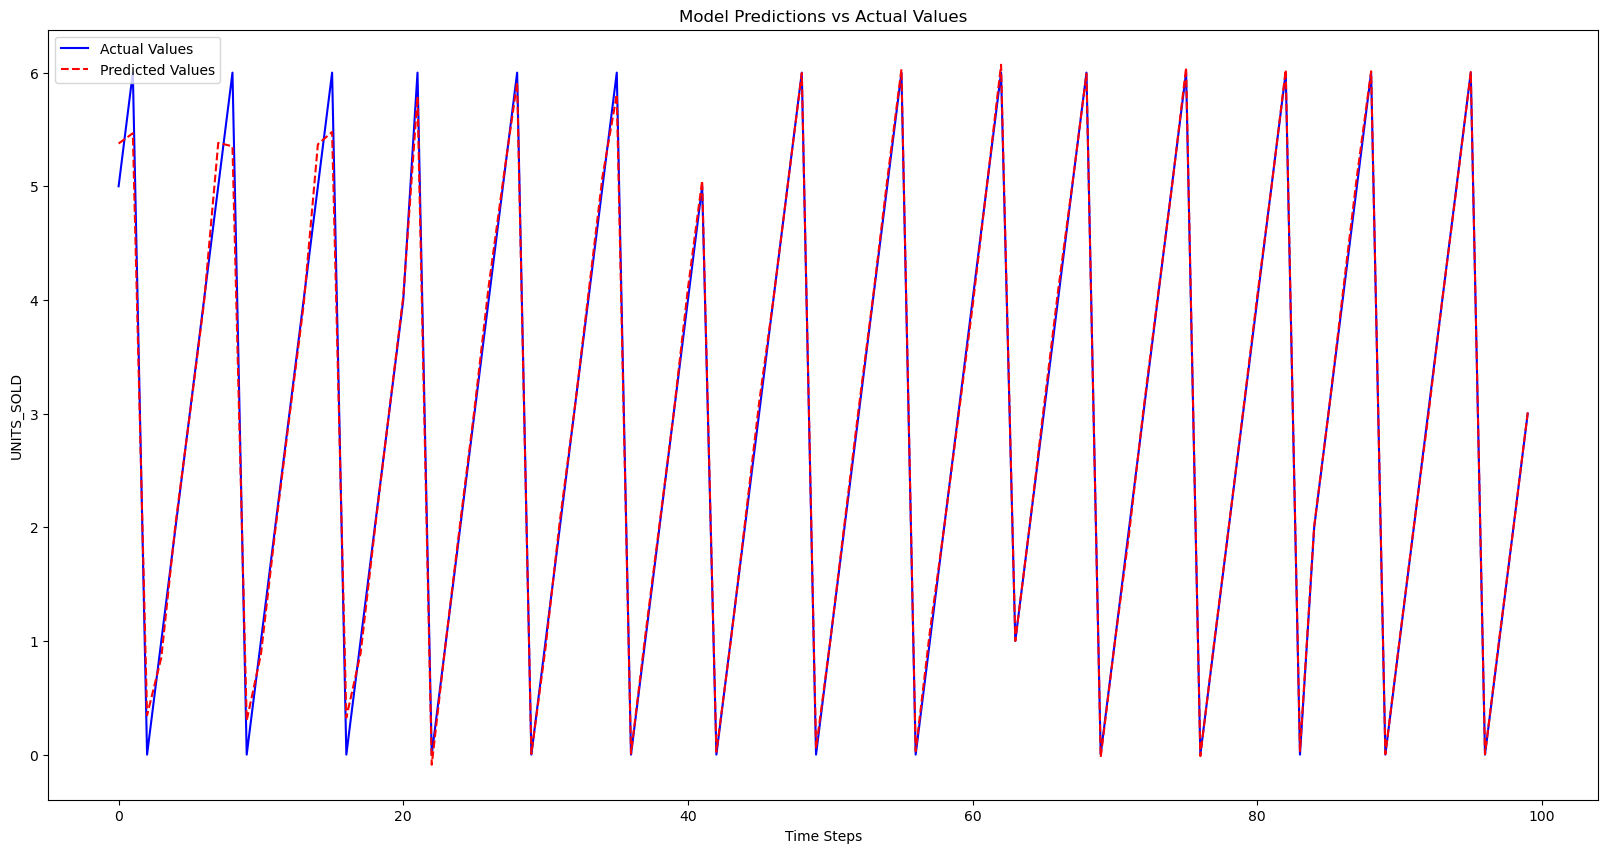

In [23]:
plot_predictions(model, data_val)